In [ ]:
# My imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
import os
import skimage.io as io

from google.colab import drive
drive.mount('/content/drive')

# Loading the images and their names, and converting them to grey scale
path = 'drive/MyDrive/samples/'
img_names = os.listdir(path)
titles = [title[:5] for title in img_names]
imgs = [io.imread(path + img + '.png', as_gray = True) for img in titles]

classes = [chr(i) for i in range(ord('a'), ord('z') + 1)]

Mounted at /content/drive


In [ ]:
from skimage.filters import threshold_otsu
from skimage.morphology import erosion, dilation
%matplotlib inline

# This function preprocesses the image
# Performing erosion, then dilation, and again dilation with different kernels in each step
def pre_process(img):
  threshold = threshold_otsu(img)
  img_binary = img > threshold

  kernel = np.ones((2,2), np.uint8)
  img_dilated = erosion(img_binary)

  kernel = np.ones((3,1), np.uint8)
  img_eroded = dilation(img_dilated, kernel)

  kernel = np.ones((4,2), np.uint8)
  img_dilated_2 = dilation(img_eroded, kernel)
  kernel = np.ones((2,1), np.uint8)
  img_f = dilation(img_dilated_2, kernel)
  img_f = dilation(img_f, kernel)

  return img_f

In [ ]:
# This functions splits each image and title into 5 character images and 5 characters respectively
def slice_and_append(img, txt):
  sliced = []
  for i in range(5):
    sliced.append({'img' : img[:, 20 * i : 20 * (i + 1)], 'char' : txt[i]})
  return sliced

In [ ]:
from sklearn.model_selection import train_test_split

l = len(imgs)

# Prepocessing the images
imgs_processed = [pre_process(img) for img in imgs]

# Splitting each image
data_set = []
for i in range(l):
  data_set.extend(slice_and_append(imgs_processed[i], titles[i]))

features, targets = np.array([data['img'] for data in data_set]), np.array([data['char'] for data in data_set])
features = features.reshape(len(features), -1)

X_train, X_validation, Y_train, Y_validation = train_test_split(features, targets, test_size=0.2, random_state=0)

In [ ]:
# This is for dividing the dataset into train and validation sets
# 80% of all images of each character will be in the train set and the rest in the validation set
# cnt => count of each character
cnt = np.zeros(26, dtype=int)
for i in data_set:
  ind = ord(i['char']) - ord('a')
  cnt[ind] = cnt[ind] + 1

each = cnt.copy()

# cnt => count of each character to be in the validation set
# Since cnt[i] will not always be a multiple of 5, the sum of all cnt[*] after dividing by 5 will not be 1000
# In this case, the sum is 990
# To get 1000, randomly cnt[i] is incremented by 1 for 10 times
sum = 0
for i in range(26):
  cnt[i] = int(cnt[i] / 5)
  sum = sum + cnt[i]
for i in range(l - sum):
  cnt[i % 26] = cnt[i % 26] + 1

train_set = []
validation_set = []

for data in data_set:
  n = ord(data['char']) - ord('a')
  if (cnt[n]):
    validation_set.append(data)
    cnt[n] = cnt[n] - 1
  else:
    train_set.append(data)

# Separating the features and targets
X_train1, Y_train1 = np.array([data['img'] for data in train_set]), np.array([data['char'] for data in train_set])
X_validation1, Y_validation1 = np.array([data['img'] for data in validation_set]), np.array([data['char'] for data in validation_set])

# Reshaping the input arrays to (n_samples, n_features) or flattening the image
# n_features = number of pixels
X_train1, X_validation1 = X_train1.reshape((len(X_train1), -1)), X_validation1.reshape((len(X_validation1), -1))

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# LogReg_model = LogisticRegression(multi_class='multinomial', solver='sag', penalty='l2', max_iter=20000)
LogReg_model = LogisticRegression()
LogReg_model.fit(X_train, Y_train)

Log_prediction = LogReg_model.predict(X_validation)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# SVMs
from sklearn.svm import SVC

# SVM_model = SVC(C=10, gamma=0.01, kernel='rbf')
SVM_model = SVC()
SVM_model.fit(X_train, Y_train)

SVM_prediction = SVM_model.predict(X_validation)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# RanFor_model = RandomForestClassifier(n_estimators=1000)
RanFor_model = RandomForestClassifier()
RanFor_model.fit(X_train, Y_train)

RanFor_prediction = RanFor_model.predict(X_validation)

In [ ]:
# ---
# -----------
# ----------------- Q1
# -----------
# ---

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

LogAccScore = accuracy_score(Y_validation, Log_prediction)

SVMAccScore = accuracy_score(Y_validation, SVM_prediction)

RanForAccScore = accuracy_score(Y_validation, RanFor_prediction)

In [ ]:
table = pd.DataFrame({"Accuracy": [LogAccScore, SVMAccScore, RanForAccScore]}, index=['Logistic Regression', 'SVMs', 'Random Forest'])

table

,Accuracy
Logistic Regression,0.578
SVMs,0.736
Random Forest,0.746


In [ ]:
# The “Random Forest Classifier” yields the best accuracy on the validation set.
# Accuracy is “not” a very good metric for evaluating classifiers because it can be
# easily manipulated by changing the decision boundary/threshold and is highly sensitive to class imbalance.
# Accuracy is the fraction of instances that are correctly classified. Suppose we have a dataset of 1000 instances,
# of which 990 are of class A and 10 are of class B. We train a classifier on this dataset and it achieves an accuracy of 99%.
# This means that the classifier correctly classifies 990 out of 1000 instances, which is a very good accuracy.
# However, that 99% of the data belongs to only one class. This means that the classifier correctly classifies only the majority class
# and has poor performance on the other class. The accuracy is very misleading in this situation.
# Precision measures the proportion of predicted positive instances that are actually positive. This means that it
# is not affected by the number of positive instances in the dataset. For example, if a model has a precision of 90%, this means that 90% of the instances
# that it predicts as positive are actually positive, regardless of whether there are 10 positive instances or 1000 positive instances in the dataset.
# Similarly, recall measures the proportion of actual positive instances that are predicted positive. Hence, precision and recall are not affected by class imbalance.
# If the decision boundary/threshold increases, precision increases and tends to 1 and if the boundary/threshold decreases, recall increases and tends to 1.
#  So, they are sensitive to changes in decision boundaries.
# “F1 score” is a value that compromises between Recall and Precision by taking the harmonic mean between them. This is a better metric for evaluation of classifiers.

In [ ]:
# ---
# -----------
# ----------------- Q2
# -----------
# ---

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [200, 500, 1000],
              'min_samples_split': [2, 3, 4],
              'criterion': ['gini', 'entropy']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True)
grid.fit(X_train1, Y_train1)
print(grid.best_params_)
Y_pred = grid.predict(X_validation1)
print(f"Classification report for classifier {grid}:")
print(classification_report(Y_validation1, Y_pred))

{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 1000}
Classification report for classifier GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'min_samples_split': [2],
                         'n_estimators': [1000]}):
              precision    recall  f1-score   support

           a       0.95      0.90      0.92        41
           b       0.69      0.69      0.69        39
           c       0.80      0.90      0.85        40
           d       0.94      0.79      0.86        38
           e       0.97      0.85      0.90        39
           f       0.56      0.47      0.51        40
           g       0.97      0.83      0.90        36
           h       0.70      0.60      0.65        35
           i       0.68      0.72      0.70        36
           j       0.59      0.95      0.73        41
           k       0.86      0.89      0.88        36
           l       0.41      0.76      0.53        41
           m      

In [ ]:
# After changing the hyperparameters
LogReg_model = LogisticRegression()
LogReg_model.fit(X_train1, Y_train1)

Log_prediction = LogReg_model.predict(X_validation1)

SVM_model = SVC()
SVM_model.fit(X_train1, Y_train1)

SVM_prediction = SVM_model.predict(X_validation1)

RanFor_model = RandomForestClassifier(n_estimators=1000)
RanFor_model.fit(X_train1, Y_train1)

RanFor_prediction = RanFor_model.predict(X_validation1)

In [ ]:
LogAccScore = accuracy_score(Y_validation1, Log_prediction)

SVMAccScore = accuracy_score(Y_validation1, SVM_prediction)

RanForAccScore = accuracy_score(Y_validation1, RanFor_prediction)

In [ ]:
table = pd.DataFrame({"Accuracy": [LogAccScore, SVMAccScore, RanForAccScore]}, index=['Logistic Regression', 'SVMs', 'Random Forest'])

table

,Accuracy
Logistic Regression,0.586
SVMs,0.741
Random Forest,0.780


In [ ]:
# We know that the Random Forest algorithm uses decision trees as blackbox (stated in the PDF).
# Each decision tree is trained on a random subset of the data, and the predictions of the individual trees
# are then combined to make a final prediction (bagging). Increasing the number of estimators in a random forest reduces the variance of the model,
# leading to better generalisation and lower over-fitting, increasing the accuracy.
# Furthermore, as the number of decision trees in the Random Forest increases, the model's complexity also increases.
# This increased complexity allows the model to capture more patterns and relationships in the data, i.e., better generalisation, which leads to improved accuracy,
# To further enhance accuracy, one can also consider modifying the train-test splits. Instead of randomly splitting
# the data into an 80-20 ratio, an alternative approach involves splitting the data in an 80-20 ratio on a character-wise basis.
# In this scenario, approximately 80% of all instances of a specific character, such as 'a', would be included in the training set,
# while the remaining instances would be assigned to the test set. This character-wise split ensures that the model receives sufficient
# exposure to each character during training, potentially leading to improved accuracy during testing.
# Random Forest algorithm that can be tuned to increase accuracy. Parameters such as max_depth, max_sample_split,
# and criterion play a significant role in determining the performance of the model. However, it's important to note that the
# optimal values for these parameters may vary depending on the dataset.
# To find the best hyperparameters for maximizing accuracy, search methods like grid search can be implemented.

# These are the values after changing the hyperparameters. (n_estimators=1000 and train-test split).
# Please note the increase in values of Logistic Regression and SVMs due to the train-test split

In [ ]:
# ---
# -----------
# ----------------- Q3
# -----------
# ---

In [ ]:
LogPreScore = precision_score(Y_validation1, Log_prediction, average='weighted')
LogRecScore = recall_score(Y_validation1, Log_prediction, average='weighted')
LogF1Score = f1_score(Y_validation1, Log_prediction, average='weighted')

SVMPreScore = precision_score(Y_validation1, SVM_prediction, average='weighted')
SVMRecScore = recall_score(Y_validation1, SVM_prediction, average='weighted')
SVMF1Score = f1_score(Y_validation1, SVM_prediction, average='weighted')

RanForPreScore = precision_score(Y_validation1, RanFor_prediction, average='weighted')
RanForRecScore = recall_score(Y_validation1, RanFor_prediction, average='weighted')
RanForF1Score = f1_score(Y_validation1, RanFor_prediction, average='weighted')

In [ ]:
table = pd.DataFrame({
    "Precision": [LogPreScore, SVMPreScore, RanForPreScore],
    "Recall": [LogRecScore, SVMRecScore, RanForRecScore],
    "F1 Score": [LogF1Score, SVMF1Score, RanForF1Score],
}, index=['Logistic Regression', 'SVMs', 'Random Forest'])

table

,Precision,Recall,F1 Score
Logistic Regression,0.589437,0.586,0.583837
SVMs,0.776656,0.741,0.747932
Random Forest,0.802417,0.780,0.784797


In [ ]:
# ---
# -----------
# ----------------- Q4
# -----------
# ---

In [ ]:
plt.figure(figsize=(7,7))
graph = plt.bar(classes, each)
plt.title("Class distribution")

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width,
             y + 100,
             str(each[i] / 50)+'%',
             rotation=90,
             ha='center', rotation_mode='anchor')
    i += 1

plt.show()

Confusion Matrix using the Random Forest Classifier RanFor_model(n_estimators=1000)


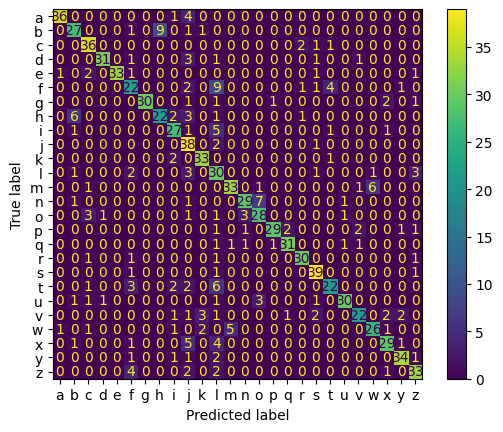

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_validation1, RanFor_prediction)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RanFor_model.classes_)
print("Confusion Matrix using the Random Forest Classifier RanFor_model(n_estimators=1000)")
display.plot()
plt.show()

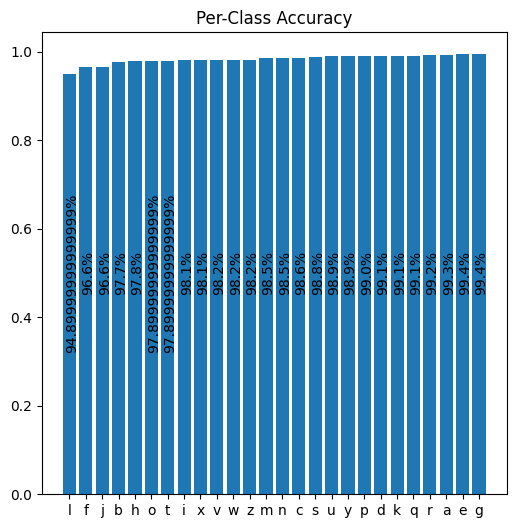

In [ ]:
# Per-Class-Accuracy calculation and plotting

accuracies = []
for i in range(26):
    true_negatives = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    true_positives = cm[i, i]
    accuracies.append({'value' : (true_positives + true_negatives) / np.sum(cm), 'char' : classes[i]})

accuracies.sort(key=lambda x:x['value'])

values, chars = [d['value'] for d in accuracies], [d['char'] for d in accuracies]

plt.figure(figsize=(6,6))
graph = plt.bar(chars, values)
plt.title("Per-Class Accuracy")

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width,
             y + 0.5,
             str(values[i] * 100)+'%',
             rotation=90,
             ha='center', rotation_mode='anchor')
    i += 1

plt.show()

In [ ]:
# The characters ‘b, f, h, i, j, l, o, t’ have low per-class-accuracies.
# The low accuracies of these characters arise from a combination of preprocessing-induced modifications and visual similarities between the alphabets. The dilation and erosion operations, while intended to enhance the image quality, resulted in unintended modifications to the characters. Furthermore, the similarities between certain alphabets made the challenges worse, making it difficult for the classification model to differentiate them accurately.
# For example, the missing or distorted dots in 'i' and 'j' resulted in misclassification as ‘l’, the
# missing horizontal line in ‘f’ and ‘t’ resulted in misclassification as’l’,
# the shortening of legs of ‘h’ resulted in misclassification as ‘n’, joining its legs resulted in misclassification as ‘b’, and both results in misclassification as ‘o’.
# This misclassifications can be observed from the confusion matrix. For instance, a ‘f’ has been misclassified as a ‘l’ 9 times.

In [ ]:
# ---
# -----------
# ----------------- Q5
# -----------
# ---

In [ ]:
# CNNs (Convolutional Neural Networks) are often considered better than Random Forest classifiers for tasks
# involving image classification because CNNs have a deeper understanding of the image features.
# They are specifically designed for analyzing images. The advantage lies in their ability to automatically learn
# and extract relevant features from images. They use a technique called convolution, which involves sliding a small
# filter across the image and capturing local patterns. These learned features are then combined to make predictions about the image content.

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Assuming you have your dataset loaded as X (input images) and y (labels)
# X shape: (5000, 100, 20)
# y shape: (5000,)

# Preprocess the input data if needed (e.g., normalize pixel values, convert labels to categorical)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split([d['img'] for d in data_set], targets, test_size=0.2, random_state=42)

# Reshape the input data to match the expected input shape of the neural network
input_shape = (100, 20, 1)
X_train = np.array(X_train1)
X_test = np.array(X_validation1)
X_train = X_train.reshape(-1, *input_shape)
X_test = X_test.reshape(-1, *input_shape)

arr = [0 for i in range(26)]

# Convert the labels to one-hot encoded vectors
num_classes = 26  # Number of classes (a-z)
y_train_vector = []
y_test_vector = []
for d in Y_train1:
  k = arr.copy()
  k[ord(d) - ord('a')] = 1
  y_train_vector.append(k)
for d in Y_validation1:
  k = arr.copy()
  k[ord(d) - ord('a')] = 1
  y_test_vector.append(k)

y_train = np.array(y_train_vector)
y_test = np.array(y_test_vector)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(26, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)
# You can use the trained model for further tasks (e.g., prediction on new, unseen data)

Epoch 1/40
125/125 [==============================] - 12s 71ms/step - loss: 2.7651 - accuracy: 0.2342 - val_loss: 2.0656 - val_accuracy: 0.4180
Epoch 2/40
125/125 [==============================] - 5s 41ms/step - loss: 1.6135 - accuracy: 0.5695 - val_loss: 1.4780 - val_accuracy: 0.5720
Epoch 3/40
125/125 [==============================] - 4s 30ms/step - loss: 1.1584 - accuracy: 0.6938 - val_loss: 1.2303 - val_accuracy: 0.6510
Epoch 4/40
125/125 [==============================] - 4s 29ms/step - loss: 0.8857 - accuracy: 0.7623 - val_loss: 1.1428 - val_accuracy: 0.6580
Epoch 5/40
125/125 [==============================] - 5s 40ms/step - loss: 0.6956 - accuracy: 0.8130 - val_loss: 1.1005 - val_accuracy: 0.6790
Epoch 6/40
125/125 [==============================] - 4s 31ms/step - loss: 0.5469 - accuracy: 0.8662 - val_loss: 1.1659 - val_accuracy: 0.6420
Epoch 7/40
125/125 [==============================] - 4s 30ms/step - loss: 0.4315 - accuracy: 0.8935 - val_loss: 1.0966 - val_accuracy: 0.684

In [ ]:
print(accuracy)

0.6710000038146973
